In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as custom_tfms
import seaborn as sns

torch.cuda.set_device(0) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df

In [2]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
label_df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(label_df)


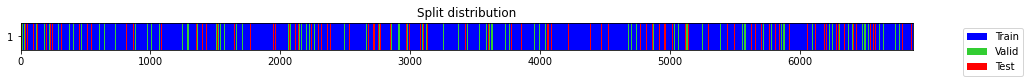

((#5503) [3730,369,1166,1104,1256,1925,1397,6851,5431,5658...],
 (#687) [3536,5567,3053,1591,268,2755,6308,2063,3139,3885...],
 (#687) [4921,3129,4389,2920,319,6726,55,1263,3608,2788...])

In [4]:
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=True, random_state=23, shuffle=True)
splits

In [5]:
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


# Study 1

In [5]:
# def objective(trial:optuna.Trial):
    
#     # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     nf = trial.suggest_int('num_filters', 16, 48, step=8) # search through all categorical values in the provided list
#     depth = trial.suggest_int('depth', 3, 9, step=3) # search through all integer values between 3 and 9 with 3 increment steps
#     dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
#     batch_tfms = TSStandardize(by_sample=True)
#     tfms  = [None, TSMultiLabelClassification()]
#     batch_tfms = [TSStandardize(by_sample=True)]
#     dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
#     dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
#     metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

#     model = InceptionTimePlus(dls.vars, dls.c, dls.len,nf=nf, fc_dropout=dropout_rate, depth=depth)
#     learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


# #     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
#     learn.fit_one_cycle(100, lr_max=learning_rate)

#     # Return the objective value
#     return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

# study_name = "inception" # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=50),sampler=optuna.samplers.RandomSampler())

# study.optimize(objective, n_trials=100)

In [6]:
# import optuna
# import pandas as pd
# import numpy as np
# import imp  
# study = optuna.load_study(study_name='inception', storage='sqlite:///inception.db')
# display(optuna.visualization.plot_optimization_history(study))
# display(optuna.visualization.plot_param_importances(study))
# display(optuna.visualization.plot_slice(study))
# display(optuna.visualization.plot_parallel_coordinate(study))

# study 2

In [7]:
# def save_callback(study, trial):
#     if study.best_trial == trial:
#         PATH = Path('./models/inception_multilabel_big.pkl')
#         PATH.parent.mkdir(parents=True, exist_ok=True)
#         global learn
#         learn.export(PATH)
# def objective(trial:optuna.Trial):    
#     # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
# #     nf = trial.suggest_int('num_filters', 16, 48, step=8) # search through all categorical values in the provided list
#     depth = trial.suggest_int('depth', 12,18,step=1) # search through all integer values between 3 and 9 with 3 increment steps
#     conv_dropout = trial.suggest_float("conv_dropout", 0.0, 0.05, step=.025) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
#     learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
#     batch_tfms = TSStandardize(by_sample=True)
#     tfms  = [None, TSMultiLabelClassification()]
#     batch_tfms = [TSStandardize(by_sample=True)]
#     dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
#     dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
#     metrics = [accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 

#     model = InceptionTimePlus(dls.vars, dls.c, dls.len,conv_dropout=conv_dropout, depth=depth)
#     global learn
#     learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


# #     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
#     learn.fit_one_cycle(150, lr_max=learning_rate)

#     # Return the objective value
#     return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

# study_name = "inception_study2" # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
#                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=75),sampler=optuna.samplers.TPESampler())

# study.optimize(objective, n_trials=100,callbacks=[save_callback])

In [ ]:
def save_callback(study, trial):
    if study.best_trial == trial:
        PATH = Path('./models/inception_multilabel.pkl')
        PATH.parent.mkdir(parents=True, exist_ok=True)
        global learn
        learn.export(PATH)
def objective(trial:optuna.Trial):    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     
    tfms = []
    random_shift = trial.suggest_float('rand_shift', 0.0, 0.5, step=.05) 
    noise = trial.suggest_float("noise", 0.0, 1.5, step=.1) 
    window_slice = trial.suggest_float("window_slice", 0.0, 0.8, step=.05) 
    rescale = trial.suggest_float("scale", 0.2, 0.8, step=.1) 
    norm = trial.suggest_categorical('normalize', [0, 1]) 
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True) 
    depth = trial.suggest_int('depth', 8,14,step=1) # search through all integer values between 3 and 9 with 3 increment steps
    conv_dropout = trial.suggest_float("conv_dropout", 0.0, 0.05, step=.025) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    fc_dropout = trial.suggest_float("fc_dropout", 0.0, 0.05, step=.025) # search through all float values between 0.0 and 0.5 with 0.1 increment steps

    nf = trial.suggest_int('num_filters', 24, 36, step=4) # search through all categorical values in the provided list
    
    Xtfms = [TSRandomShift(magnitude=random_shift),TSMagMulNoise(noise),TSWindowSlicing(magnitude=window_slice),custom_tfms.Resample(scale_factor=rescale)]
    if norm!=0:
        Xtfms.append(custom_tfms.Normalize())
    
    batch_tfms = TSStandardize(by_sample=True)
    tfms  = [None, TSMultiLabelClassification()]
    batch_tfms = [TSStandardize(by_sample=True)]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=Xtfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[F1_multi] 

    model = InceptionTimePlus(dls.vars, dls.c, dls.len, conv_dropout=conv_dropout, depth=depth,fc_dropout = fc_dropout,nf = nf)
    global learn
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(), cbs=FastAIPruningCallback(trial))


#     with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
    learn.fit_one_cycle(100, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][-1] # return the f1 value and try to maximize it

study_name = "inception_study3" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.PatientPruner(optuna.pruners.MedianPruner(n_warmup_steps=25),patience=20),)

study.optimize(objective, n_trials=100,callbacks=[save_callback])

,1st degree av block,atrial fibrillation,left bundle branch block,premature atrial contraction,right bundle branch block,sinus rhythm,st depression,st elevation,ventricular ectopics
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,True,False,False,False
2,False,True,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...
6872,True,False,False,False,False,False,False,False,False
6873,False,False,False,False,False,False,True,False,False
6874,False,False,True,False,False,False,False,False,False
6875,False,True,False,False,False,False,False,False,False


epoch,train_loss,valid_loss,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,1.045809,0.971490,0.247865,0.750056,0.693039,0.372487,00:28
1,0.901733,0.839920,0.296187,0.767587,0.753966,0.427285,00:28
2,0.809833,0.773266,0.318135,0.792229,0.771205,0.453869,00:30
3,0.752523,0.770774,0.373236,0.801818,0.818739,0.509217,00:29
4,0.681876,0.697041,0.412087,0.841690,0.838186,0.553037,00:30
5,0.659961,0.674703,0.408089,0.838622,0.835975,0.548750,00:29
6,0.651706,0.640418,0.428523,0.846744,0.847548,0.568796,00:29
7,0.623338,0.637314,0.416241,0.882412,0.833413,0.565516,00:30
8,0.597558,0.650393,0.423206,0.852855,0.843140,0.565256,00:30
9,0.597413,0.611306,0.478680,0.888364,0.869564,0.621703,00:29


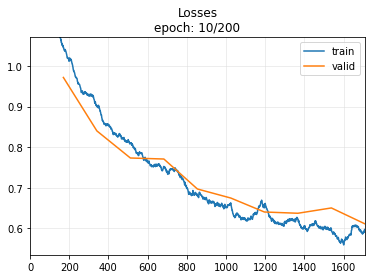

In [ ]:
import transformation_funcs as custom_tfms

tfms = [[TSRandomShift(magnitude=0.2),TSMagMulNoise(),custom_tfms.TSNormalize(),TSWindowSlicing(magnitude=0.2)],TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[32, 128], batch_tfms=batch_tfms, num_workers=0) 
# reorganize y dataframe using dl's label/vocab mapping and count pos_weights
y = y[dls.vocab.o2i.keys()]
pos_weights = (len(y)-y.sum())/(y.sum()+1e-5)
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=13,)
learn = Learner(dls, model, metrics=metrics, loss_func=nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight)),cbs=ShowGraph())
learn.fit_one_cycle(200, lr_max=0.004178080960048705)
learn.recorder.plot_metrics()

In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, conv_dropout=0.05, depth=10,)
learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph())
learn.fit_one_cycle(100, lr_max=0.0018562679873326028)
learn.recorder.plot_metrics()

In [8]:
# PATH = Path('./models/inception_multilabel_bestparam.pkl')
# PATH.parent.mkdir(parents=True, exist_ok=True)
# learn.export(PATH)

In [19]:
PATH = Path('./models/inception_multilabel_small.pkl')
learn = load_learner(PATH, cpu=False)

In [22]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True)]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(splits[0],splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred=np.argmax(valid_preds, axis=1)
y_test=np.argmax(valid_targets, axis=1)

print(classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys()))

                              precision    recall  f1-score   support

         1st degree av block       0.94      0.92      0.93        73
         atrial fibrillation       0.95      0.93      0.94       122
    left bundle branch block       1.00      0.85      0.92        20
premature atrial contraction       0.87      0.81      0.84        59
   right bundle branch block       0.93      0.94      0.94       162
                sinus rhythm       0.93      0.90      0.92        92
               st depression       0.84      0.90      0.87        80
                st elevation       0.76      0.72      0.74        18
        ventricular ectopics       0.84      0.93      0.88        61

                    accuracy                           0.91       687
                   macro avg       0.90      0.88      0.89       687
                weighted avg       0.91      0.91      0.91       687



In [ ]:
classification_report(y_test, y_pred,target_names = df.columns)

In [ ]:
[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]
["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"]
[0.86,0.87,0.95,0.50,0.87,0.66,0.75, 0.48,0.64]
["RBBB","PVC","AF","LBBBB","STE","I-AVB","PAC","normal","STD"]
[0.90,0.88,0.95,0.43,0.88,0.73,0.74, 0.67,0.64]
["RBBB","PVC","AF","LBBBB","STE","I-AVB","PAC","normal","STD"]

In [22]:
to_beat = dict(zip(["normal","AF","I-AVB","LBBB","RBBB","PAC","PVC","STD","STE"],[0.795,0.897,0.865,0.821,0.911,0.734,0.852,0.788,0.509]))
best = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.86,0.87,0.95,0.50,0.87,0.66,0.75, 0.48,0.64]))
augmented_best = dict(zip(["RBBB","PVC","AF","LBBB","STE","I-AVB","PAC","normal","STD"],[0.90,0.88,0.95,0.43,0.88,0.73,0.74, 0.67,0.64]))

to_beat = dict(sorted(to_beat.items()))
best = dict(sorted(best.items()))
augmented_best = dict(sorted(augmented_best.items()))
df = pd.DataFrame([to_beat,best,augmented_best],index=["winner","ours","augmented"]).T

In [25]:
df["better"] = df["winner"]<df["ours"]
df

,winner,ours,augmented,better
AF,0.897,0.95,0.95,True
I-AVB,0.865,0.66,0.73,False
LBBB,0.821,0.50,0.43,False
PAC,0.734,0.75,0.74,True
PVC,0.852,0.87,0.88,True
RBBB,0.911,0.86,0.90,False
STD,0.788,0.64,0.64,False
STE,0.509,0.87,0.88,True
normal,0.795,0.48,0.67,False
